In [ ]:
import os
import re
import pandas as pd

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

!mkdir input

Поместите файлы в формате txt в папку input или руками введите текст на следующем шаге

In [27]:
path = './input/'

files = []
for r, d, f in os.walk(path):
    for file in f:
        if '.txt' in file:
            files.append(os.path.join(r, file))

text = ""
            
for f in files:
    text_part = open(f, 'rb').read().decode(encoding='utf-8')
    print('Length of text: {} characters'.format(len(text_part)))
    text = text + text_part

len(text)

Length of text: 495884 characters
Length of text: 67331 characters
Length of text: 527641 characters
Length of text: 50937 characters
Length of text: 606230 characters
Length of text: 943663 characters
Length of text: 565794 characters
Length of text: 785511 characters
Length of text: 608365 characters


4651356

или введи строку

In [28]:
text = "Человек читает большую и тяжелую книгу за столом. Стол выглядит древним, пошарпанные края красного дерева давно выцвели. Внезапный порыв ветра через открытое окно задувает свечи. В комнате воцарился мрак. Отложив книгу, он встает."

установим natasha

In [6]:
!pip install natasha

     |████████████████████████████████| 34.4MB 1.3MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
     |████████████████████████████████| 51kB 4.0MB/s 
     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 8.2MB 35.3MB/s 
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26102 sha256=d66cd565ce48c511ee048691d69d5037b6b1b2277ea675c56575cf92965b8641
  Stored in directory: /root/.cache/pip/wheels/f3/f2/66/e9c30d3e9499e65ea2fa0d07c002e64de63bd0adaa49c445bf
Successfully built intervaltree
  Found existing installation: intervaltree 2.1.0
    Uninstalling intervaltree-2.1.0:
      Successfully uninstalled intervaltree-2.1.0


In [30]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

In [31]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

функция выделения сущностей

In [32]:
def get_entities_ru(sent):
    doc = Doc(sent)
    doc.segment(segmenter)
    doc.parse_syntax(syntax_parser)
    doc.tag_ner(ner_tagger)
    doc.tag_morph(morph_tagger)

    root_id = False  

    for token in doc.tokens:
        try:
            token.lemmatize(morph_vocab)
        except:
            pass

    array_sent = {}

    for i in doc.tokens:
        if i.lemma != 'None':
            array_sent[i.id] = i.lemma
        else:
            array_sent[i.id] = i.text

    array_sent_head_id = {i.id: i.head_id for i in doc.tokens}

    # main action
    for i in doc.tokens:
      if i.rel == 'root':
        root_id = i.id
        break

    # cases
    array_result_new = []
    for i in doc.tokens:
      if i.rel == 'case' and i.head_id in array_sent_head_id and i.head_id in array_sent and array_sent_head_id[i.head_id] in array_sent:
        array_result_new.append([array_sent[array_sent_head_id[i.head_id]], array_sent[i.head_id], i.lemma])

    if not root_id and len(array_result_new) < 1:
        return False       

    array_result = [i.lemma for i in doc.tokens if i.head_id == root_id and i.rel != 'punct' and i.rel != 'case']

    # main
    if len(array_result) == 1:
        array_result_new.append([array_result[0], '', array_sent[root_id]])
    elif len(array_result) == 2:
        array_result_new.append([array_result[0], array_result[1], array_sent[root_id]])
    elif len(array_result) > 2:        
        for word_first_id in range(0,len(array_result)):
            for word_second_id in range(word_first_id + 1, len(array_result)):
                array_result_new.append([array_result[word_first_id], array_result[word_second_id], array_sent[root_id]])

    return array_result_new

In [33]:
entities = []

for text_sent in tqdm(text.split('. ')):
    if len(text_sent.split(' ')) > 1:
        result = get_entities_ru(text_sent)
        if result and result != None:
            entities += result

100%|██████████| 5/5 [00:00<00:00, 57.67it/s]


функция сохранения

In [34]:
def save_entity(entity_pairs, name='phrases.csv'):
    # extract subject
    source = [i[0] for i in entity_pairs]

    # extract object
    target = [i[1] for i in entity_pairs]

    # relation
    relations = [i[2] for i in entity_pairs]

    kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

    kg_df.to_csv(name)

    return kg_df

In [35]:
entity_pairs_df = save_entity(entities, 'phrases.csv')

функция построения графика

In [36]:
def plot_graph(entity_pairs):
    # extract subject
    source = [i[0] for i in entity_pairs]

    # extract object
    target = [i[1] for i in entity_pairs]

    # relation
    relations = [i[2] for i in entity_pairs]

    kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

    # create a directed-graph from a dataframe
    G=nx.from_pandas_edgelist(kg_df, "source", "target", create_using=nx.MultiDiGraph())

    fig = plt.figure(figsize=(12,12))

    pos = nx.spring_layout(G)
    nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)

    formatted_edge_labels = {(row['source'],row['target']):row['edge'] for index, row in kg_df.iterrows()} # use this to modify the tuple keyed dict if it has > 2 elements, else ignore
    nx.draw_networkx_edge_labels(G,pos,edge_labels=formatted_edge_labels,font_color='red')

    plt.show()

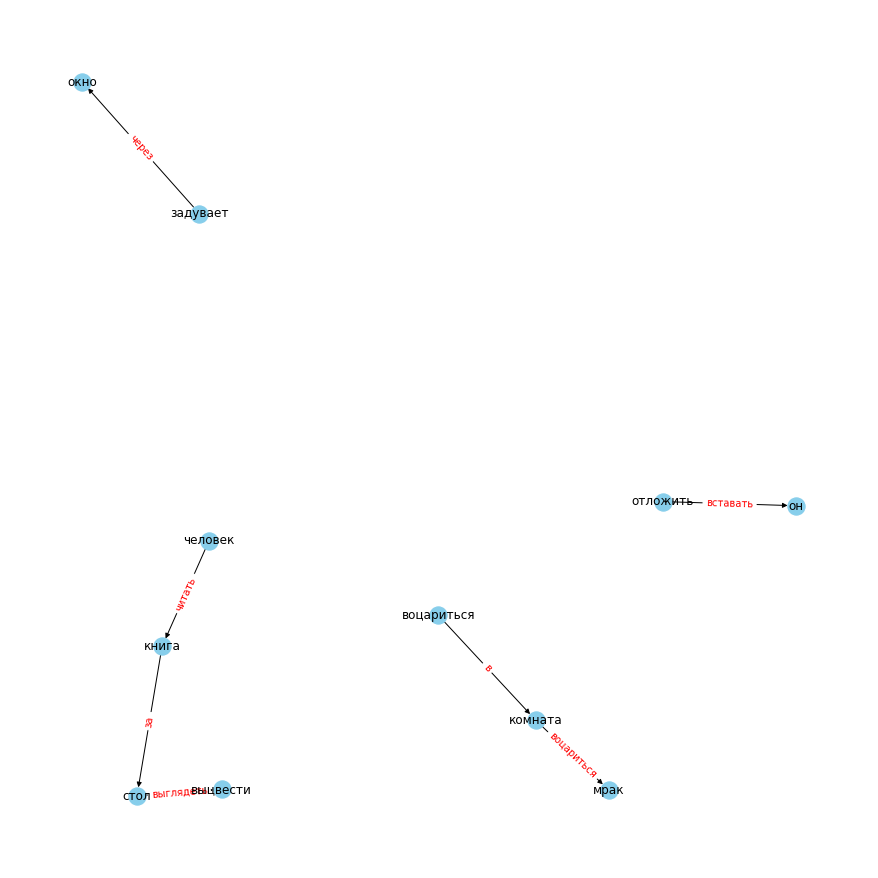

In [37]:
plot_graph(entities)